<a href="https://colab.research.google.com/github/lisannebleiksch/SyntData/blob/main/InhollandModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importeer libraries & data



In [87]:
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from catboost import CatBoostClassifier,Pool,cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
# import shap

In [88]:
# URL to the raw file
url = 'https://raw.githubusercontent.com/lisannebleiksch/SyntData/main/SupermarktDataset.xlsx'

# Reading the Excel file into a DataFrame
df = pd.read_excel(url, engine='openpyxl')

df.head()

,CustomerName,Age,Income,Gender,SignUpDate,WebsiteVisits,Q1,Q2,Q3,Q4,...,Vis_Q3,Vis_Q4,Snoepgoed_Q1,Snoepgoed_Q2,Snoepgoed_Q3,Snoepgoed_Q4,Fruit_Q1,Fruit_Q2,Fruit_Q3,Fruit_Q4
0,Neva Cooper,49,30227,F,2011-06-17,18,1014,1084.91,1066.06,981.55,...,14.02,14.36,14.76,17.30,22.84,26.75,11.55,19.77,15.01,18.55
1,Doyle Jeffords,53,31031,M,2013-06-07,16,1171,1215.78,1197.46,1200.08,...,20.50,11.42,10.95,22.32,23.23,16.00,26.17,20.07,14.69,21.64
2,Jose Davis,67,51000,M,2005-01-30,19,2091,2052.34,2078.83,2061.36,...,11.99,20.75,22.44,16.25,29.53,20.27,10.03,20.05,19.56,10.68
3,Hugh Kieser,54,20028,M,2009-09-12,15,2359,2326.64,2587.67,2146.48,...,22.45,25.36,15.97,19.82,17.68,16.49,13.56,25.95,25.11,20.21
4,Nicole Mccarthy,65,48433,F,2020-10-24,25,1163,1092.55,1215.95,1093.48,...,29.37,22.42,19.14,10.22,12.83,17.50,10.21,23.79,24.34,25.44


#Definieer een doelvariabele
De doelvariabele (ook bekend als de afhankelijke variabele) is de uitkomst of het resultaat dat je wilt voorspellen met behulp van andere beschikbare data (kenmerken of onafhankelijke variabelen). In de context van jouw project met de supermarktdata, zou je bijvoorbeeld willen voorspellen of er een omzetdaling zal plaatsvinden. De doelvariabele zou in dit geval een indicator zijn (bijvoorbeeld 0 of 1) die aangeeft of de omzet meer dan een bepaald percentage is gedaald.

##Waarom moet je een doelvariabele maken?
- Richting aan het model geven: De doelvariabele geeft de richting aan het model over wat er precies voorspeld moet worden. Het is het fundament waarop het hele model wordt gebouwd.
- Training van het model: In supervised learning leert het model patronen te herkennen in de data die correleren met de uitkomst die door de doelvariabele wordt aangegeven. Zonder een duidelijk gedefinieerde doelvariabele heeft het model geen referentiepunt om te "leren" wat belangrijk is.
- Evaluatie van de prestaties: Met een duidelijk gedefinieerde doelvariabele kun je na het trainen van het model controleren hoe nauwkeurig het de uitkomsten kan voorspellen. Dit wordt gedaan door de voorspellingen van het model te vergelijken met de werkelijke waarden van de doelvariabele in de testset.

##Hoe kies je een geschikte doelvariabele?
- Relevantie: De doelvariabele moet relevant zijn voor de zakelijke of onderzoeksvragen die je probeert te beantwoorden. In jouw geval, als je geïnteresseerd bent in het begrijpen of voorspellen van omzetdalingen, zou je een variabele kiezen die deze daling representeert.
- Meetbaarheid: De doelvariabele moet duidelijk meetbaar en definieerbaar zijn, idealiter op een manier die consistent is over tijd en voorbeelden heen.
- Beschikbaarheid: Je moet toegang hebben tot historische data voor de doelvariabele voor het trainen van het model.


In [89]:
# Bereken het percentage daling tussen de kwartalen
df['daling_q1_q2'] = ((df['Q1'] - df['Q2']) / df['Q1']) * 100
df['daling_q2_q3'] = ((df['Q2'] - df['Q3']) / df['Q2']) * 100
df['daling_q3_q4'] = ((df['Q3'] - df['Q4']) / df['Q3']) * 100

# Definieer de doelvariabele voor omzetdaling (1 = daling > 6%, 0 = anders)
df['omzet_daling'] = ((df['daling_q1_q2'] < 0) | (df['daling_q2_q3'] < 0) | (df['daling_q3_q4'] <0)).astype(int)


#Features
Features zijn de variabelen die je gebruikt als input voor je model. Deze kunnen kwantitatieve metingen zijn, zoals de hoeveelheid verkochte producten, of kwalitatieve attributen, zoals de categorie van een product of demografische gegevens van klanten. Het idee is om die variabelen te selecteren die mogelijk een invloed hebben op de doelvariabele die je probeert te voorspellen.

##Hoe kies je de juiste Features?
- Relevantie: Kies features die relevant zijn voor de doelvariabele. Vraag jezelf af: "Is er een logische reden waarom deze feature de uitkomst zou beïnvloeden?" Bijvoorbeeld, als je omzetdaling wilt voorspellen, kunnen features zoals klantbestedingen in voorgaande perioden, promotieactiviteiten, en economische indicatoren relevant zijn.
- Datakwaliteit: Zorg ervoor dat de data die je als features gebruikt van hoge kwaliteit zijn. Dit betekent dat ze nauwkeurig, volledig, en consistent verzameld zijn. Vermijd features met veel ontbrekende waarden of die inaccuraat zijn.
- Diversiteit van de data: Probeer een diverse set aan features te gebruiken die verschillende aspecten van het probleem belichten. Dit kan helpen om een robuuster model te bouwen. Bijvoorbeeld, naast directe verkoopcijfers kun je ook demografische gegevens van klanten en seizoensinvloeden meenemen.
- Onafhankelijkheid: Idealiter moeten de features onafhankelijk van elkaar zijn. Hoog gecorreleerde features (multicollineariteit) kunnen het model minder effectief maken en de interpretatie bemoeilijken.
- Dimensionaliteit: Meer features betekent niet altijd een beter model. Te veel features kunnen leiden tot overfitting, waarbij het model te specifiek wordt getraind op de trainingsdata en daardoor minder goed presteert op nieuwe data. Gebruik technieken zoals feature selection en feature importance om de meest impactvolle features te identificeren.

In [90]:
# Converteer 'signup_date' naar een datetime object
df['signup_date'] = pd.to_datetime(df['SignUpDate'])

# Extract year, month, day, and day of week
df['signup_year'] = df['signup_date'].dt.year
df['signup_month'] = df['signup_date'].dt.month
df['signup_day'] = df['signup_date'].dt.day
df['signup_weekday'] = df['signup_date'].dt.weekday  # Maandag=0, Zondag=6

# One-hot encode de 'gender' kolom
df_encoded = pd.get_dummies(df, columns=['Gender'])

# Voorbereid je features (zorg dat je de relevante kolommen kiest)
# Vermijd data leakage door kwartaalomzet of direct afgeleide kolommen niet als feature te gebruiken
# List of column names to use as features
# feature_columns = [
#     'Age', 'Income', 'Gender_F', "Gender_M", 'WebsiteVisits', "Snoepgoed_Q1","Snoepgoed_Q2", "Snoepgoed_Q3","Snoepgoed_Q4", "Fruit_Q1","Fruit_Q2","Fruit_Q3","Fruit_Q4", "Vlees_Q1", "Vlees_Q2","Vlees_Q3","Vlees_Q4", "Vis_Q1", "Vis_Q2", "Vis_Q3","Vis_Q4"
# ]

# Voorbeeld input features
feature_columns = [
    'Age', 'Income', 'Gender_F', "Gender_M", 'WebsiteVisits', 'signup_year']

print(df_encoded.head())

      CustomerName  Age  Income  SignUpDate  WebsiteVisits    Q1       Q2  \
0      Neva Cooper   49   30227  2011-06-17             18  1014  1084.91   
1   Doyle Jeffords   53   31031  2013-06-07             16  1171  1215.78   
2       Jose Davis   67   51000  2005-01-30             19  2091  2052.34   
3      Hugh Kieser   54   20028  2009-09-12             15  2359  2326.64   
4  Nicole Mccarthy   65   48433  2020-10-24             25  1163  1092.55   

        Q3       Q4  Groente_Q1  ...  daling_q2_q3  daling_q3_q4  \
0  1066.06   981.55       29.55  ...      1.737471      7.927321   
1  1197.46  1200.08       18.13  ...      1.506852     -0.218796   
2  2078.83  2061.36       23.20  ...     -1.290722      0.840377   
3  2587.67  2146.48       13.73  ...    -11.219183     17.049701   
4  1215.95  1093.48       26.09  ...    -11.294678     10.071960   

   omzet_daling  signup_date  signup_year  signup_month  signup_day  \
0             1   2011-06-17         2011             6  

#Een Random Forest Model
Een Random Forest is een ensemble leermethode die gebruikt wordt voor classificatie en regressie. Het bouwt meerdere beslissingsbomen tijdens de training en geeft de output door het gemiddelde van de voorspellingen van de individuele bomen te nemen (in het geval van regressie) of door stemming (in het geval van classificatie).

##Voordelen van Random Forest:
- Robuustheid: Door het gemiddelde van meerdere bomen te nemen, zijn Random Forests minder gevoelig voor overfitting dan individuele beslissingsbomen.
- Hoge nauwkeurigheid: Vaak levert het hoge nauwkeurigheid in veel praktische toepassingen.
- Belang van features: Kan inzicht geven in het belang van elke feature bij het doen van voorspellingen.
- Flexibiliteit: Kan zowel voor classificatie als voor regressie worden gebruikt.

##Training van het Model
De training van een Random Forest model omvat een paar cruciale stappen:

- Data voorbereiden: Dit heb je al gedaan door je dataset te verwerken, categorische variabelen om te zetten met one-hot encoding, en het splitsen van je data in kenmerken (X) en labels (y).
- Splitsing van dataset: De dataset wordt gewoonlijk verdeeld in een trainingset en een testset. De trainingset wordt gebruikt om het model te trainen, terwijl de testset wordt gebruikt om de nauwkeurigheid van het model te evalueren. Dit helpt bij het beoordelen van hoe goed het model zal presteren op ongeziene data.
- Model initialiseren en trainen: Hier creëer je een instantie van het Random Forest model en train je dit met de trainingsdata.
- Voorspellingen doen en evalueren: Na het trainen van het model gebruik je het om voorspellingen te doen op de testset, en dan evalueer je de prestaties van het model.

In [91]:
 # Selecteer de kenmerken en de nieuwe doelvariabele
X = df_encoded[feature_columns]
y = df_encoded['omzet_daling']

# Splits de data in train- en testsets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train de Random Forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)

# Voorspel en evalueer
y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'De nauwkeurigheid van het model is: {accuracy:.2f}')

De nauwkeurigheid van het model is: 0.98


#Evaluatie van het Model
De prestaties van het model kunnen worden geëvalueerd met verschillende metrics, afhankelijk van het type probleem (classificatie of regressie). Voor classificatie zijn enkele veelgebruikte metrics:

- Accuracy: Het percentage van de correct voorspelde observaties tot het totaal.
- Precision en Recall: Vooral belangrijk in situaties waar sommige klassen meer belang hebben of ongelijk verdeeld zijn.
- F1-Score: De harmonische gemiddelde van precision en recall.
- Confusion Matrix: Een tabel die laat zien hoe goed het model presteert voor elke klasse van de doelvariabele.

               importance
Income           0.664671
Gender_M         0.105540
Gender_F         0.099667
Age              0.051981
WebsiteVisits    0.043719
signup_year      0.034421


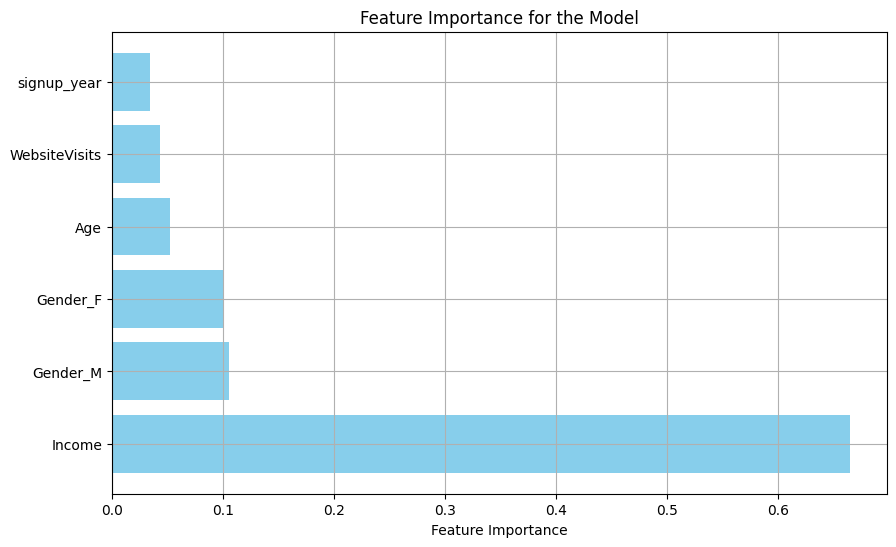

In [92]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = x_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

# Maak de grafiek
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for the Model')
plt.grid(True)
plt.show()

#Conclusies
- Inkomen is een belangrijke factor: Met een importance-waarde van 0.665214 domineert het inkomen duidelijk in het model. Dit suggereert dat het inkomen een aanzienlijke rol speelt in de voorspelling, wat erop wijst dat klanten met verschillende inkomensniveaus significant verschillend gedrag kunnen vertonen. Dit zou bijvoorbeeld kunnen betekenen dat klanten met een lager inkomen meer geneigd zijn tot churn, hoewel voor directe conclusies over het gedrag van specifieke groepen meer specifieke analyse vereist is.
- Verschillen tussen geslachten: Gender_F en Gender_M hebben ook relatief hoge importance-waarden (0.115450 en 0.092603 respectievelijk), wat aangeeft dat geslacht ook een belangrijke rol speelt in het model. Het verschil in importance tussen Gender_F en Gender_M kan wijzen op verschillende churn-rates tussen mannen en vrouwen.


#Vervolgstappen en Aanbevelingen
Na de analyse van de feature importance, waarbij inkomen als de meest bepalende factor naar voren kwam en geslacht ook significant bleek, zijn hier enkele vervolgstappen en strategieën die de supermarkt kan overwegen om het churnen onder vrouwen met een laag inkomen te verminderen:

1. Diepgaander Onderzoek naar het Effect van Inkomen en Geslacht
Segmentanalyse: Voer een gedetailleerde segmentanalyse uit om de specifieke behoeften en gedragingen van vrouwen met een laag inkomen te begrijpen. Dit kan onder meer het analyseren van kooppatronen, productvoorkeuren, en de frequentie van winkelbezoeken omvatten.
Correlatiestudies: Onderzoek de correlatie tussen churn en andere variabelen zoals productcategorieën, promotiegevoeligheid, en seizoensgebonden koopgedrag binnen dit segment.
2. Marketing en Promotiestrategieën
Gerichte Promoties: Ontwikkel promoties en kortingen die specifiek gericht zijn op de producten die populair zijn onder vrouwen met een laag inkomen. Dit kan helpen om de waardeperceptie en klantloyaliteit te verhogen.
Loyaliteitsprogramma's: Introduceer of optimaliseer loyaliteitsprogramma's die beloningen bieden die aantrekkelijk zijn voor deze doelgroep, zoals korting op basisbehoeften, beloningen voor herhaalaankopen, of speciale aanbiedingen.
3. Verbetering van de Klantenservice
Persoonlijke Service: Bied meer gepersonaliseerde service in de winkel, wellicht door training van personeel om beter in te spelen op de behoeften van deze specifieke groep. Dit kan helpen bij het opbouwen van een emotionele band met de klant.
Feedback en Klachtenbehandeling: Zorg voor een robuust systeem voor het verzamelen van feedback en het efficiënt afhandelen van klachten, specifiek gericht op dit segment, om verbeterpunten snel te identificeren en aan te pakken.
4. Productaanbod en Plaatsing
Betaalbare Alternatieven: Zorg dat er altijd betaalbare alternatieven beschikbaar zijn naast premium producten. Overweeg een 'budgetvriendelijk' label of schapindeling die gemakkelijk te herkennen is voor klanten die prijsgevoelig zijn.
Gezonde Opties: Bied gezonde, betaalbare voedselopties aan. Dit kan helpen om het merkimago te verbeteren en klanten aan te trekken die gezondheid hoog in het vaandel hebben maar beperkte financiële middelen.
5. Communicatiestrategie
Effectieve Communicatiekanalen: Identificeer en gebruik de communicatiekanalen die het meest effectief zijn voor het bereiken van vrouwen met een laag inkomen. Dit kan variëren van traditionele media zoals lokale kranten en radio tot digitale media, afhankelijk van hun toegankelijkheid en bereik binnen deze doelgroep.
Educatieve Campagnes: Voer campagnes die de voordelen van bepaalde producten of winkelbezoeken benadrukken, gericht op het verhogen van de kennis van budgetbeheer en gezond eten.

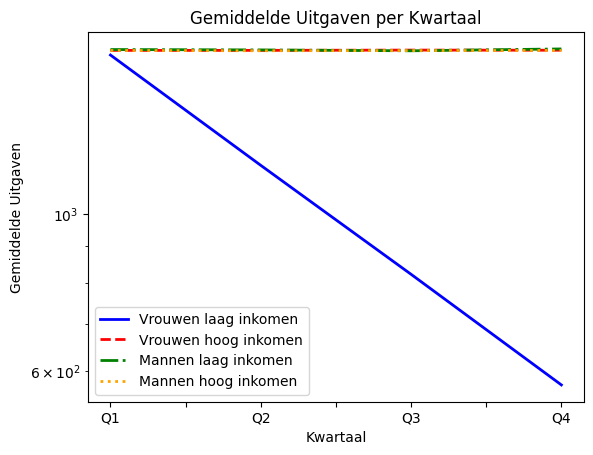

In [93]:
INCOME_THRESHOLD = 24000  # Drempel voor laag inkomen (jaarbasis)
# Filter de DataFrame voor vrouwen met een laag inkomen
low_income_women = df[(df['Gender'] == 'F') & (df['Income'] < INCOME_THRESHOLD)]
av_per_quarter_low_inc_women = low_income_women[['Q1', 'Q2', 'Q3', 'Q4']].mean()

av_per_quarter_women1  = df[(df['Gender'] == 'F') & (df['Income'] > INCOME_THRESHOLD)]
av_per_quarter_women = av_per_quarter_women1[['Q1', 'Q2', 'Q3', 'Q4']].mean()

av_per_quarter_man1  = df[(df['Gender'] == 'M')& (df['Income'] > INCOME_THRESHOLD)]
av_per_quarter_man = av_per_quarter_man1[['Q1', 'Q2', 'Q3', 'Q4']].mean()

per_quarter_low_inc_man = df[(df['Gender'] == 'M') & (df['Income'] < INCOME_THRESHOLD)]
av_per_quarter_low_inc_man = per_quarter_low_inc_man[['Q1', 'Q2', 'Q3', 'Q4']].mean()

av_per_quarter_low_inc_women.plot(kind='line', label='Vrouwen laag inkomen', linewidth=2, linestyle='-', color='blue')
av_per_quarter_women.plot(kind='line', label='Vrouwen hoog inkomen', linewidth=2, linestyle='--', color='red')
av_per_quarter_low_inc_man.plot(kind='line', label='Mannen laag inkomen', linewidth=2, linestyle='-.', color='green')
av_per_quarter_man.plot(kind='line', label='Mannen hoog inkomen', linewidth=2, linestyle=':', color='orange')
plt.title('Gemiddelde Uitgaven per Kwartaal')
plt.xlabel('Kwartaal')
plt.legend()
plt.yscale('log')
plt.ylabel('Gemiddelde Uitgaven')
plt.show()
# plt.savefig('GemiddeldeInkomen.png')
